# Notebook to explore visual processing

In this notebook we implement several scenarios to test the robustness of the visual processing.

The video that were produced using this code are on the drive  (https://drive.google.com/drive/u/1/folders/1RxnbTyR-75OWsPtSnCLu-PBjjf7ijszE) under the name '4_colored_....mp4'.

In [1]:
from flygym import Camera, Simulation
import cv2
import numpy as np
from tqdm import trange
import flygym as flygym
from flygym.arena import FlatTerrain
from flygym.preprogrammed import all_leg_dofs
from flygym.vision import save_video_with_vision_insets

In [2]:
from scripts.utils import plot_chasing, plot_overlayed_frames
from scripts.target_fly import TargetFly
from scripts.changing_state_fly import ChangingStateFly
from scripts.colored_terrain import FlatTerrainColored

## Robustness to fly color

### With original Chasing Fly parameters

General parameters

In [3]:
timestep = 1e-4
run_time = 3
t = np.arange(0, run_time, timestep)

Flies

In [4]:
fly1 = TargetFly(
    name="1",
    timestep=timestep,
    enable_adhesion=True,
    spawn_pos=(6, 0, 0.5),
)

fly0 = ChangingStateFly(
    name="0",
    timestep=timestep,
    enable_adhesion=True,
    head_stabilization_model="thorax",
    neck_kp=1000,
)

Arena

In [5]:
arena = FlatTerrain()

Cameras

In [6]:
birdeye_cam_zoom = arena.root_element.worldbody.add(
    "camera",
    name="birdeye_cam_zoom",
    mode="fixed",
    pos=(15, 0, 20),
    euler=(0, 0, 0),
    fovy=45,
)

birdeye_cam = arena.root_element.worldbody.add(
    "camera",
    name="birdeye_cam",
    mode="fixed",
    pos=(15, 0, 35),
    euler=(0, 0, 0),
    fovy=45,
)

cam = Camera(
    fly=fly0,
    camera_id="birdeye_cam",
    play_speed=0.5,
    window_size=(800, 608),
)

Simulation

In [7]:
sim = Simulation(
    flies=[fly0, fly1],
    cameras=[cam],
    arena=arena,
    timestep=timestep,
)

Target fly actions

In [4]:
# Define fly 1 actions --> sinusoidal trajectory
speed_variation = np.abs(np.sin(t * np.pi / 2))
fly1_actions = np.zeros((len(t), 2))  

# Create the fly 1 actions scenario
for i, time in enumerate(t):
    fly1_actions[i] = (
        np.abs(np.cos(time * np.pi / 2)) * speed_variation[i],
        np.abs(np.sin(time * np.pi / 2)) * speed_variation[i],
    ) 

# Modifiy fly speed
mean_speed = 1.2  
std_dev_speed = 0.4  

# fly1_actions *= random_speed_variation
fly1_actions = np.clip(fly1_actions, 0, 2 * mean_speed)

In [9]:
# Reset the simulation and set fly 1 to be black
sim.reset(seed=0)
# for i in fly1.model.find_all("geom"):
#     sim.physics.named.model.geom_rgba[f"1/{i.name}"] = (0, 0, 0, 1)

# Prepare simulation
second_cam_frames = []
fly0_action = np.zeros(2)
x = None
alpha = 1e-1

# Prepare variables to plot 
proximities = []
speeds_fly0 = []
speeds_fly1 = []
positions_fly0 = []
positions_fly1 = []
fly1_vision_left = []
fly1_vision_right = []
wings_extension = []

# Run simulation for each timepoint
for i in trange(len(t)):
    obs, _, _, _, info = sim.step(
        {
            "0": fly0_action,
            "1": fly1_actions[i],
        }
    )

    # Get observations for fly 0
    obs0, info0 = obs["0"], info["0"]
    render_res = sim.render()[0]
    velocity0 = obs0["fly"][1]
    v0 = np.linalg.norm(velocity0)

    # Get observations for fly 1
    obs1, info1 = obs["1"], info["1"]
    velocity1 = obs1["fly"][1]
    v1 = np.linalg.norm(velocity1)

    # If frame is rendered, save it
    if render_res is not None:
        fly0.visual_inputs_hist.append(obs0["vision"].copy())
        second_cam = sim.physics.bind(birdeye_cam_zoom)

        x_new = sim._get_center_of_mass()[0]

        if x is None:
            x = x_new

        x = (1 - alpha) * x + alpha * x_new

        second_cam.pos[0] = x
        second_img = sim.physics.render(
            width=700, height=560, camera_id="birdeye_cam_zoom"
        )
        second_img = cv2.putText(
            np.ascontiguousarray(second_img),
            f"{sim.cameras[0].play_speed}x",
            org=(20, 30),
            fontFace=cv2.FONT_HERSHEY_DUPLEX,
            fontScale=0.8,
            color=(0, 0, 0),
            lineType=cv2.LINE_AA,
            thickness=1,
        )
        second_cam_frames.append(second_img)

    # Process visual input for fly 0
    curr_time = i * sim.timestep
    fly0_action, proximity = fly0.get_action(obs0, curr_time)

    # Process visual input for fly 1
    # fly1_features, left_deviation, right_deviation, left_found, right_found = fly1.process_visual_observation(obs1['vision'])
    fly1_features, chasing_fly = fly1.process_visual_observation(obs1['vision'])

    # Save variables for plotting
    proximities.append(proximity)
    speeds_fly0.append(v0)
    speeds_fly1.append(v1)
    positions_fly0.append(obs0["fly"][0])
    positions_fly1.append(obs1["fly"][0])
    fly1_vision_left.append(chasing_fly[0])
    fly1_vision_right.append(chasing_fly[1])
    wings_extension.append(fly0.wings_state)

100%|██████████| 30000/30000 [59:20<00:00,  8.43it/s]  


In [10]:
birdeye_cam_frames = cam._frames
cam._frames = second_cam_frames
sim.fly = fly0

save_video_with_vision_insets(
    sim,
    cam,
    "outputs/4_colored_fly_original.mp4",
    fly0.visual_inputs_hist,
)

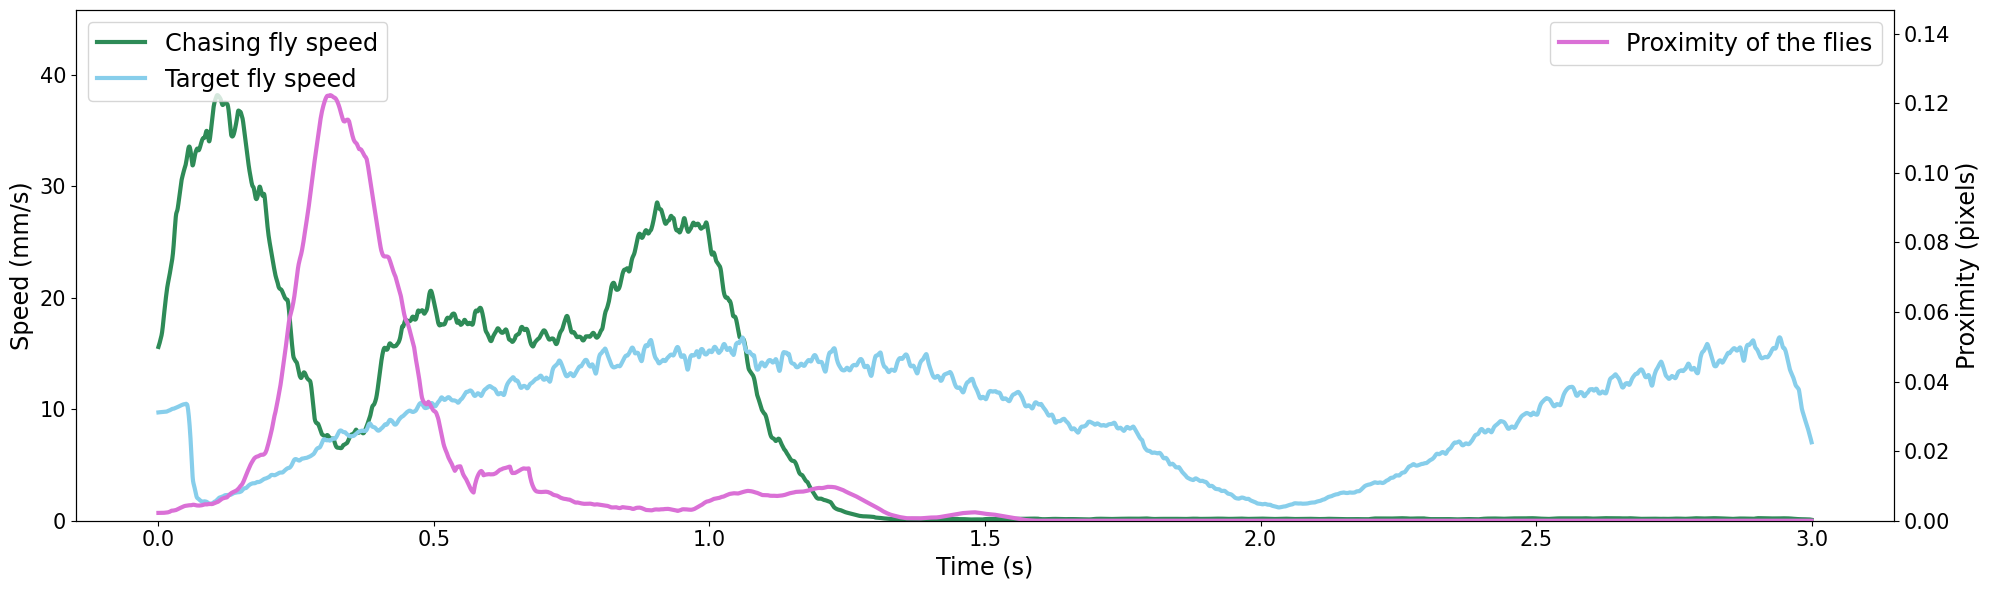

In [11]:
plot_chasing(t, speeds_fly0, speeds_fly1, proximities)

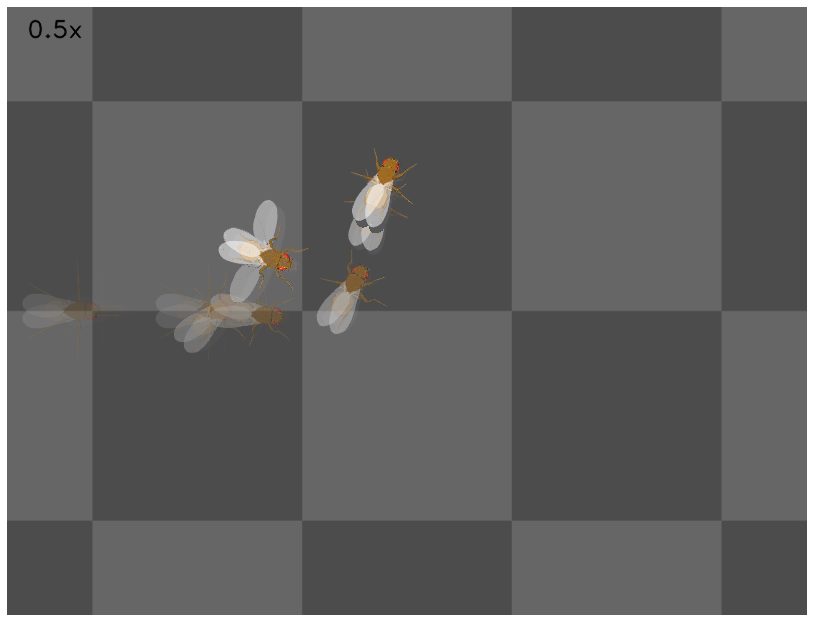

In [12]:
plot_overlayed_frames(birdeye_cam_frames, 5)

### With updated desired distance

General parameters

In [62]:
timestep = 1e-4
run_time = 3
t = np.arange(0, run_time, timestep)

Flies

In [63]:
fly1 = TargetFly(
    name="1",
    timestep=timestep,
    enable_adhesion=True,
    spawn_pos=(6, 0, 0.5),
)

fly0 = ChangingStateFly(
    name="0",
    timestep=timestep,
    enable_adhesion=True,
    head_stabilization_model="thorax",
    neck_kp=1000,
    desired_distance=0.005, 
)

Arena

In [64]:
arena = FlatTerrain()

Cameras

In [65]:
birdeye_cam_zoom = arena.root_element.worldbody.add(
    "camera",
    name="birdeye_cam_zoom",
    mode="fixed",
    pos=(15, 0, 20),
    euler=(0, 0, 0),
    fovy=45,
)

birdeye_cam = arena.root_element.worldbody.add(
    "camera",
    name="birdeye_cam",
    mode="fixed",
    pos=(15, 0, 35),
    euler=(0, 0, 0),
    fovy=45,
)

cam = Camera(
    fly=fly0,
    camera_id="birdeye_cam",
    play_speed=0.5,
    window_size=(800, 608),
)

Simulation

In [66]:
sim = Simulation(
    flies=[fly0, fly1],
    cameras=[cam],
    arena=arena,
    timestep=timestep,
)

Target fly actions

In [11]:
# Define fly 1 actions --> sinusoidal trajectory
speed_variation = np.abs(np.sin(t * np.pi / 2))
fly1_actions = np.zeros((len(t), 2))  

# Create the fly 1 actions scenario
for i, time in enumerate(t):
    fly1_actions[i] = (
        np.abs(np.cos(time * np.pi / 2)) * speed_variation[i],
        np.abs(np.sin(time * np.pi / 2)) * speed_variation[i],
    ) 

# Modifiy fly speed
mean_speed = 1.2  
std_dev_speed = 0.4  

# fly1_actions *= random_speed_variation
fly1_actions = np.clip(fly1_actions, 0, 2 * mean_speed)

In [68]:
# Reset the simulation and set fly 1 to be black
sim.reset(seed=0)
# for i in fly1.model.find_all("geom"):
#     sim.physics.named.model.geom_rgba[f"1/{i.name}"] = (0, 0, 0, 1)

# Prepare simulation
second_cam_frames = []
fly0_action = np.zeros(2)
x = None
alpha = 1e-1

# Prepare variables to plot 
proximities = []
speeds_fly0 = []
speeds_fly1 = []
positions_fly0 = []
positions_fly1 = []
fly1_vision_left = []
fly1_vision_right = []
wings_extension = []

# Run simulation for each timepoint
for i in trange(len(t)):
    obs, _, _, _, info = sim.step(
        {
            "0": fly0_action,
            "1": fly1_actions[i],
        }
    )

    # Get observations for fly 0
    obs0, info0 = obs["0"], info["0"]
    render_res = sim.render()[0]
    velocity0 = obs0["fly"][1]
    v0 = np.linalg.norm(velocity0)

    # Get observations for fly 1
    obs1, info1 = obs["1"], info["1"]
    velocity1 = obs1["fly"][1]
    v1 = np.linalg.norm(velocity1)

    # If frame is rendered, save it
    if render_res is not None:
        fly0.visual_inputs_hist.append(obs0["vision"].copy())
        second_cam = sim.physics.bind(birdeye_cam_zoom)

        x_new = sim._get_center_of_mass()[0]

        if x is None:
            x = x_new

        x = (1 - alpha) * x + alpha * x_new

        second_cam.pos[0] = x
        second_img = sim.physics.render(
            width=700, height=560, camera_id="birdeye_cam_zoom"
        )
        second_img = cv2.putText(
            np.ascontiguousarray(second_img),
            f"{sim.cameras[0].play_speed}x",
            org=(20, 30),
            fontFace=cv2.FONT_HERSHEY_DUPLEX,
            fontScale=0.8,
            color=(0, 0, 0),
            lineType=cv2.LINE_AA,
            thickness=1,
        )
        second_cam_frames.append(second_img)

    # Process visual input for fly 0
    curr_time = i * sim.timestep
    fly0_action, proximity = fly0.get_action(obs0, curr_time)

    # Process visual input for fly 1
    # fly1_features, left_deviation, right_deviation, left_found, right_found = fly1.process_visual_observation(obs1['vision'])
    fly1_features, chasing_fly = fly1.process_visual_observation(obs1['vision'])

    # Save variables for plotting
    proximities.append(proximity)
    speeds_fly0.append(v0)
    speeds_fly1.append(v1)
    positions_fly0.append(obs0["fly"][0])
    positions_fly1.append(obs1["fly"][0])
    fly1_vision_left.append(chasing_fly[0])
    fly1_vision_right.append(chasing_fly[1])
    wings_extension.append(fly0.wings_state)

100%|██████████| 30000/30000 [40:45<00:00, 12.27it/s]  


In [69]:
birdeye_cam_frames = cam._frames
cam._frames = second_cam_frames
sim.fly = fly0

save_video_with_vision_insets(
    sim,
    cam,
    "outputs/4_colored_fly_updated.mp4",
    fly0.visual_inputs_hist,
)

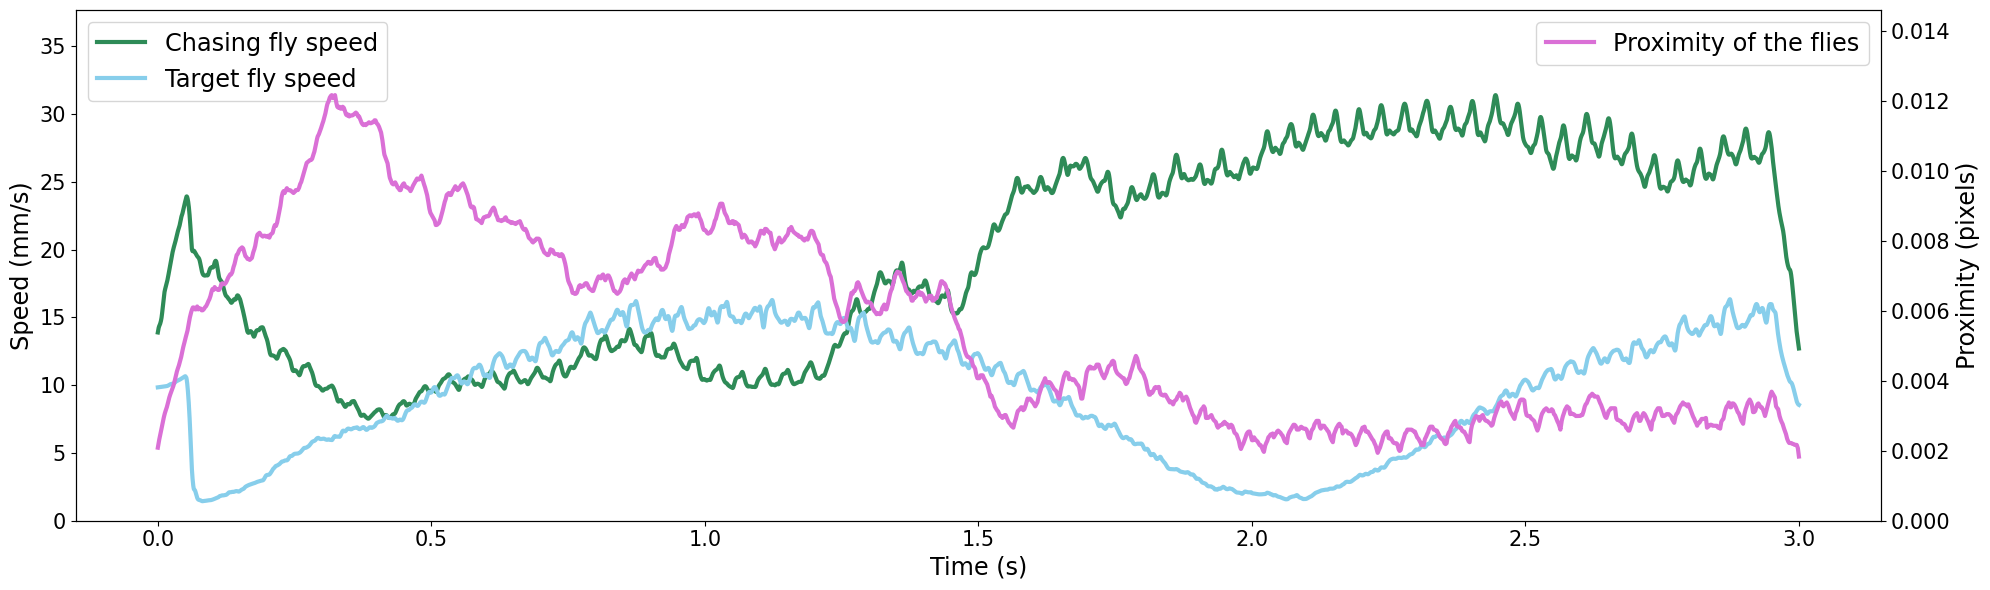

In [70]:
plot_chasing(t, speeds_fly0, speeds_fly1, proximities)

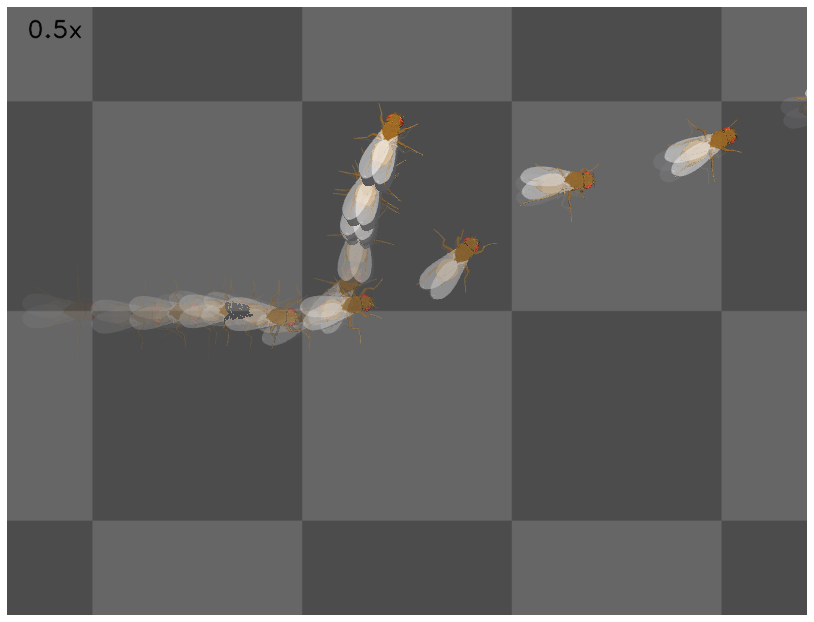

In [71]:
plot_overlayed_frames(birdeye_cam_frames)

## Colored terrain

### With original parameters

General parameters

In [4]:
timestep = 1e-4
run_time = 3
t = np.arange(0, run_time, timestep)

Flies

In [5]:
fly1 = TargetFly(
    name="1",
    timestep=timestep,
    enable_adhesion=True,
    spawn_pos=(6, 0, 0.5),
)

fly0 = ChangingStateFly(
    name="0",
    timestep=timestep,
    enable_adhesion=True,
    head_stabilization_model="thorax",
    neck_kp=1000,
)

Arena

In [6]:
rgb1 = (1, 0.984, 0)
rgb2 = (1, 0, 0)
arena = FlatTerrainColored(rgb1=rgb1, rgb2=rgb2)

Cameras

In [7]:
birdeye_cam_zoom = arena.root_element.worldbody.add(
    "camera",
    name="birdeye_cam_zoom",
    mode="fixed",
    pos=(15, 0, 20),
    euler=(0, 0, 0),
    fovy=45,
)

birdeye_cam = arena.root_element.worldbody.add(
    "camera",
    name="birdeye_cam",
    mode="fixed",
    pos=(15, 0, 35),
    euler=(0, 0, 0),
    fovy=45,
)

cam = Camera(
    fly=fly0,
    camera_id="birdeye_cam",
    play_speed=0.5,
    window_size=(800, 608),
)

In [8]:
sim = Simulation(
    flies=[fly0, fly1],
    cameras=[cam],
    arena=arena,
    timestep=timestep,
)

In [12]:
# Reset the simulation and set fly 1 to be black
sim.reset(seed=0)
for i in fly1.model.find_all("geom"):
    sim.physics.named.model.geom_rgba[f"1/{i.name}"] = (0, 0, 0, 1)

# Prepare simulation
second_cam_frames = []
fly0_action = np.zeros(2)
x = None
alpha = 1e-1

# Prepare variables to plot 
proximities = []
speeds_fly0 = []
speeds_fly1 = []
positions_fly0 = []
positions_fly1 = []
fly1_vision_left = []
fly1_vision_right = []
wings_extension = []

# Run simulation for each timepoint
for i in trange(len(t)):
    obs, _, _, _, info = sim.step(
        {
            "0": fly0_action,
            "1": fly1_actions[i],
        }
    )

    # Get observations for fly 0
    obs0, info0 = obs["0"], info["0"]
    render_res = sim.render()[0]
    velocity0 = obs0["fly"][1]
    v0 = np.linalg.norm(velocity0)

    # Get observations for fly 1
    obs1, info1 = obs["1"], info["1"]
    velocity1 = obs1["fly"][1]
    v1 = np.linalg.norm(velocity1)

    # If frame is rendered, save it
    if render_res is not None:
        fly0.visual_inputs_hist.append(obs0["vision"].copy())
        second_cam = sim.physics.bind(birdeye_cam_zoom)

        x_new = sim._get_center_of_mass()[0]

        if x is None:
            x = x_new

        x = (1 - alpha) * x + alpha * x_new

        second_cam.pos[0] = x
        second_img = sim.physics.render(
            width=700, height=560, camera_id="birdeye_cam_zoom"
        )
        second_img = cv2.putText(
            np.ascontiguousarray(second_img),
            f"{sim.cameras[0].play_speed}x",
            org=(20, 30),
            fontFace=cv2.FONT_HERSHEY_DUPLEX,
            fontScale=0.8,
            color=(0, 0, 0),
            lineType=cv2.LINE_AA,
            thickness=1,
        )
        second_cam_frames.append(second_img)

    # Process visual input for fly 0
    curr_time = i * sim.timestep
    fly0_action, proximity = fly0.get_action(obs0, curr_time)

    # Process visual input for fly 1
    # fly1_features, left_deviation, right_deviation, left_found, right_found = fly1.process_visual_observation(obs1['vision'])
    fly1_features, chasing_fly = fly1.process_visual_observation(obs1['vision'])

    # Save variables for plotting
    proximities.append(proximity)
    speeds_fly0.append(v0)
    speeds_fly1.append(v1)
    positions_fly0.append(obs0["fly"][0])
    positions_fly1.append(obs1["fly"][0])
    fly1_vision_left.append(chasing_fly[0])
    fly1_vision_right.append(chasing_fly[1])
    wings_extension.append(fly0.wings_state)

100%|██████████| 30000/30000 [33:16<00:00, 15.03it/s] 


In [13]:
birdeye_cam_frames = cam._frames
cam._frames = second_cam_frames
sim.fly = fly0

save_video_with_vision_insets(
    sim,
    cam,
    "outputs/4_colored_terrain_original.mp4",
    fly0.visual_inputs_hist,
)

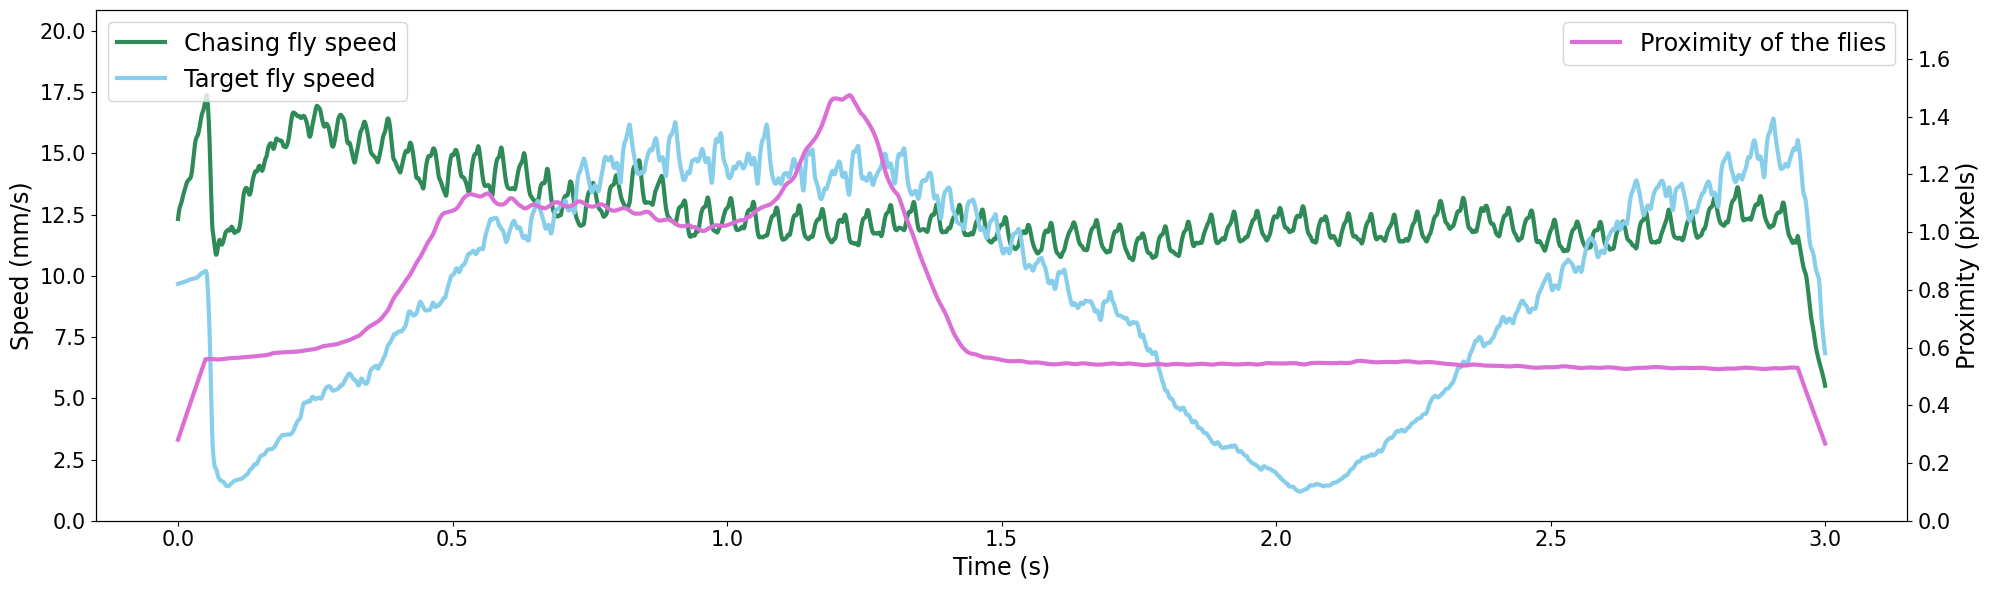

In [14]:
plot_chasing(t, speeds_fly0, speeds_fly1, proximities)

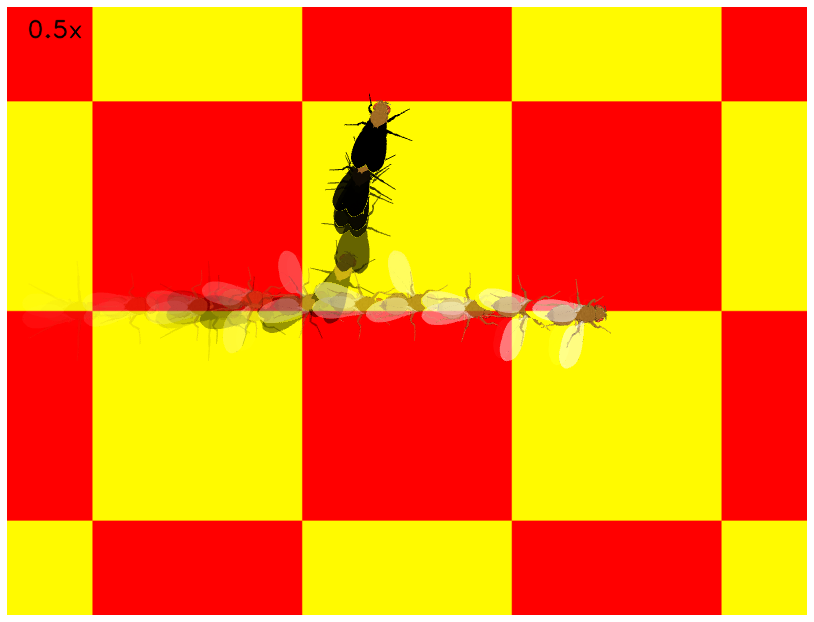

In [15]:
plot_overlayed_frames(birdeye_cam_frames)

### With updated desired distance

General parameters

In [43]:
timestep = 1e-4
run_time = 3
t = np.arange(0, run_time, timestep)

Flies

In [21]:
fly1 = TargetFly(
    name="1",
    timestep=timestep,
    enable_adhesion=True,
    spawn_pos=(6, 0, 0.5),
)

fly0 = ChangingStateFly(
    name="0",
    timestep=timestep,
    enable_adhesion=True,
    head_stabilization_model="thorax",
    neck_kp=1000,
    desired_distance=0.7
)

Arena

In [22]:
rgb1 = (1, 0.984, 0)
rgb2 = (1, 0, 0)
arena = FlatTerrainColored(rgb1=rgb1, rgb2=rgb2)

Cameras

In [23]:
birdeye_cam_zoom = arena.root_element.worldbody.add(
    "camera",
    name="birdeye_cam_zoom",
    mode="fixed",
    pos=(15, 0, 20),
    euler=(0, 0, 0),
    fovy=45,
)

birdeye_cam = arena.root_element.worldbody.add(
    "camera",
    name="birdeye_cam",
    mode="fixed",
    pos=(15, 0, 35),
    euler=(0, 0, 0),
    fovy=45,
)

cam = Camera(
    fly=fly0,
    camera_id="birdeye_cam",
    play_speed=0.5,
    window_size=(800, 608),
)

In [24]:
sim = Simulation(
    flies=[fly0, fly1],
    cameras=[cam],
    arena=arena,
    timestep=timestep,
)

In [25]:
# Reset the simulation and set fly 1 to be black
sim.reset(seed=0)
for i in fly1.model.find_all("geom"):
    sim.physics.named.model.geom_rgba[f"1/{i.name}"] = (0, 0, 0, 1)

# Prepare simulation
second_cam_frames = []
fly0_action = np.zeros(2)
x = None
alpha = 1e-1

# Prepare variables to plot 
proximities = []
speeds_fly0 = []
speeds_fly1 = []
positions_fly0 = []
positions_fly1 = []
fly1_vision_left = []
fly1_vision_right = []
wings_extension = []

# Run simulation for each timepoint
for i in trange(len(t)):
    obs, _, _, _, info = sim.step(
        {
            "0": fly0_action,
            "1": fly1_actions[i],
        }
    )

    # Get observations for fly 0
    obs0, info0 = obs["0"], info["0"]
    render_res = sim.render()[0]
    velocity0 = obs0["fly"][1]
    v0 = np.linalg.norm(velocity0)

    # Get observations for fly 1
    obs1, info1 = obs["1"], info["1"]
    velocity1 = obs1["fly"][1]
    v1 = np.linalg.norm(velocity1)

    # If frame is rendered, save it
    if render_res is not None:
        fly0.visual_inputs_hist.append(obs0["vision"].copy())
        second_cam = sim.physics.bind(birdeye_cam_zoom)

        x_new = sim._get_center_of_mass()[0]

        if x is None:
            x = x_new

        x = (1 - alpha) * x + alpha * x_new

        second_cam.pos[0] = x
        second_img = sim.physics.render(
            width=700, height=560, camera_id="birdeye_cam_zoom"
        )
        second_img = cv2.putText(
            np.ascontiguousarray(second_img),
            f"{sim.cameras[0].play_speed}x",
            org=(20, 30),
            fontFace=cv2.FONT_HERSHEY_DUPLEX,
            fontScale=0.8,
            color=(0, 0, 0),
            lineType=cv2.LINE_AA,
            thickness=1,
        )
        second_cam_frames.append(second_img)

    # Process visual input for fly 0
    curr_time = i * sim.timestep
    fly0_action, proximity = fly0.get_action(obs0, curr_time)

    # Process visual input for fly 1
    # fly1_features, left_deviation, right_deviation, left_found, right_found = fly1.process_visual_observation(obs1['vision'])
    fly1_features, chasing_fly = fly1.process_visual_observation(obs1['vision'])

    # Save variables for plotting
    proximities.append(proximity)
    speeds_fly0.append(v0)
    speeds_fly1.append(v1)
    positions_fly0.append(obs0["fly"][0])
    positions_fly1.append(obs1["fly"][0])
    fly1_vision_left.append(chasing_fly[0])
    fly1_vision_right.append(chasing_fly[1])
    wings_extension.append(fly0.wings_state)

100%|██████████| 30000/30000 [31:53<00:00, 15.68it/s] 


In [26]:
birdeye_cam_frames = cam._frames
cam._frames = second_cam_frames
sim.fly = fly0

save_video_with_vision_insets(
    sim,
    cam,
    "outputs/4_colored_terrain_updated.mp4",
    fly0.visual_inputs_hist,
)

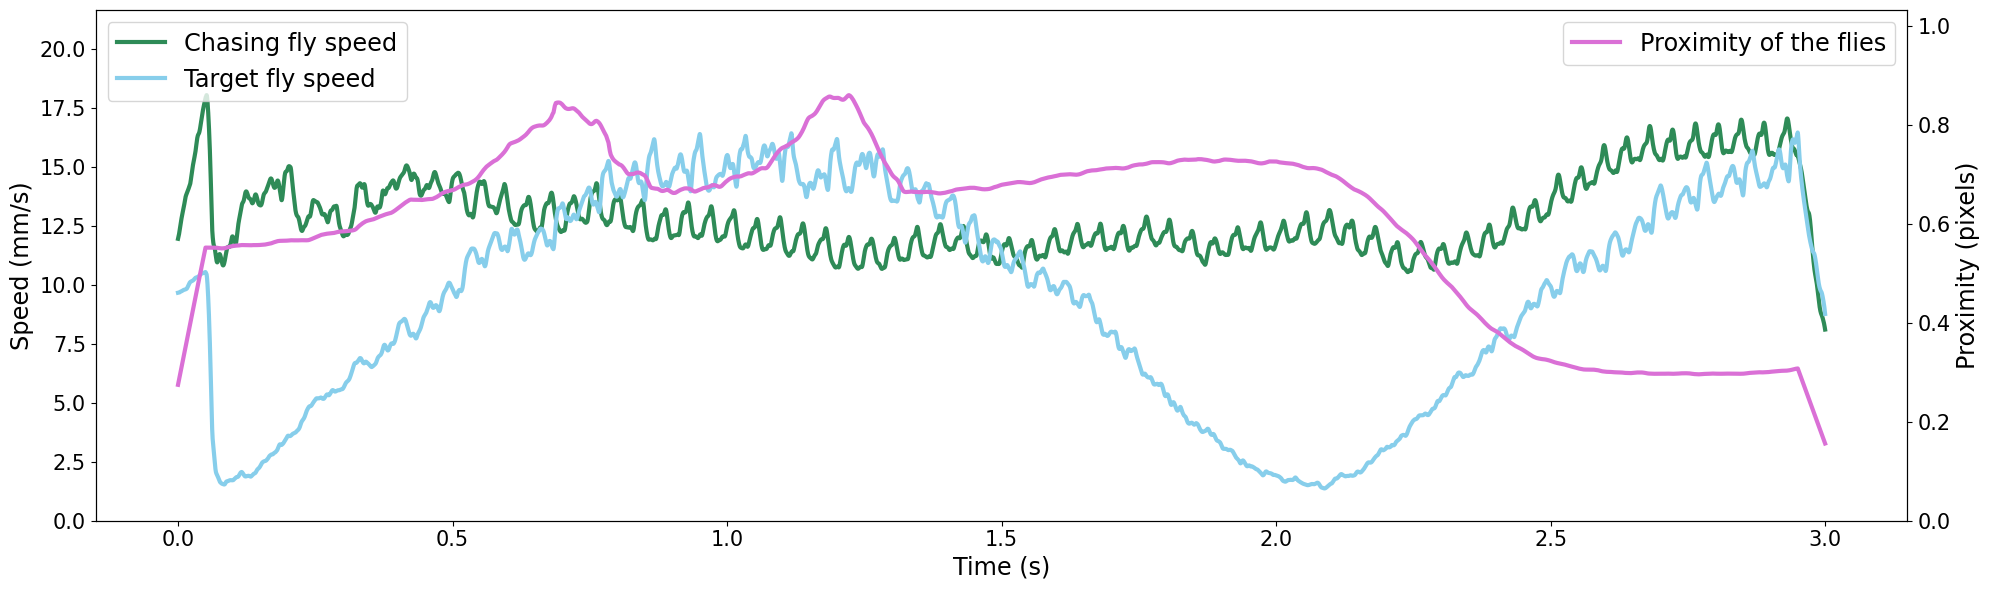

In [27]:
plot_chasing(t, speeds_fly0, speeds_fly1, proximities)

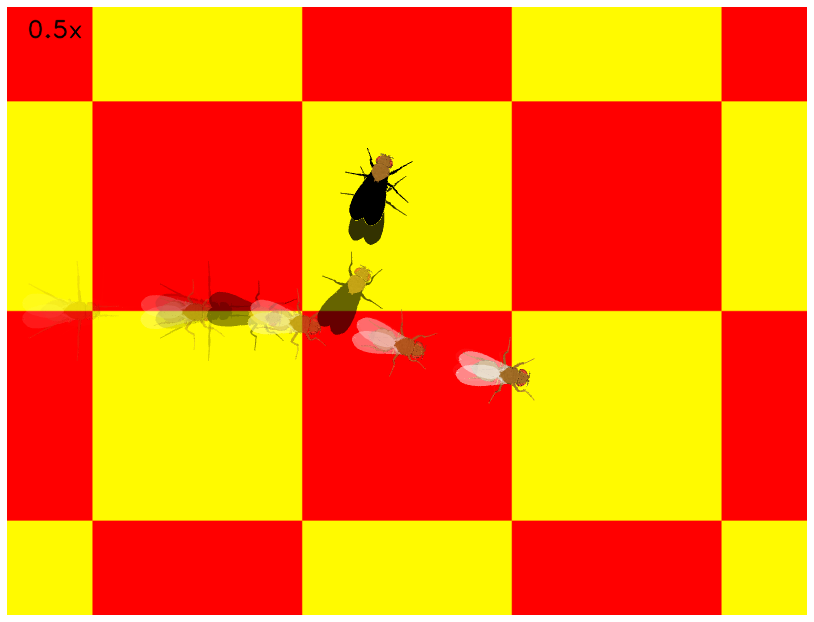

In [28]:
plot_overlayed_frames(birdeye_cam_frames, 5)